<a href="https://colab.research.google.com/github/wenko99/Standalone_DDL/blob/master/Lec09/Lec09_Simpsons_Classification_sk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simpsons Classification

<br/>

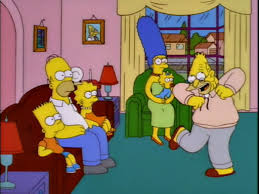

<br/>

오늘의 코딩실습은, **The Simpsons** 애니메이션에 나오는 등장인물들의 이미지를 분류하는 것입니다!

Simpson 가족의 구성원인, Abraham, Homer, Marge, Bart, Lisa, Maggie Simpson의 사진들을 분류하는 것이죠.

지난 시간까지 다룬 EMNIST Dataset과는 다르게, 컬러 사진이 들어갑니다. 또한, 사진의 크기도 더 큽니다!

또, Dataset의 크기가 더 작아졌습니다!

좋은 Model을 Train시키기가 더 어려워졌겠죠?

적절한 Hyperparameter 조합을 찾고, Image Augmentation을 통해 Dataset을 늘려주면 좋은 Model을 만들 수 있지 않을까요?!

<br/>

아래는 이번 코딩실습에서 해야 할 일들입니다.

직접 구현해야 하는 부분들은 **BOLD**처리했습니다.

1. Download Simpsons Dataset

2. Preprocess Simpsons Dataset

3. Data Visualization

4. **Image Augmentation : Manually / via Keras**

5. **Construct Model**

6. Train Model

7. Model Visualization

8. Export Model

<br/>

본격적으로 **Simpsons Classification**을 시작해 봅시다!

<br/>

Dataset from, [[Kaggle](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset)]

<br/>

##Download Simpsons Datset

<br/>

먼저, Dataset을 준비해야겠죠?

Google Drive와 Google Colab을 연동시켜 줄까요?

본인의 Google Drive 첫 화면에 Simpsons 폴더를 생성하신 후, 안에 simpsons_dataset 폴더를 업로드해 주세요!

첫 코드 셀을 실행하면 나오는 링크를 타고 가셔서, Google Drive에 대한 접근을 허용해주신 후, Authorization Code를 빈칸에 채워 넣어 주세요!

아래의 코드 셀들을 모두 실행했을 때, **simpsons_dataset**이 나오면 잘 하신 것입니다!

<br/>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
cd drive/My Drive/Simpsons

/content/drive/My Drive/Colab Notebooks/DDL/Simpsons


In [0]:
ls

jaehyunlee_googlenet_simpsonslab_architecture.json  simpsons_dataset/
jaehyunlee_googlenet_simpsonslab_weights.h5         simpsons_models/
may_be_marge.jpg                                    simpsons_testset/


## Preprocess Simpsons Dataset

<br/>

simpsons_dataset 안에는 여러 폴더들이 있습니다.

각 폴더명은 애니메이션의 캐릭터 이름인데요, 각각의 폴더 안에는 캐릭터들의 사진이 있습니다.

우선 이러한 이미지들을 변수에 저장해 주어야겠죠?

그러려면, jpg 파일을 RGB 채널을 가진 Tensor로 바꿔 주어야 할 것입니다.

Simpsons Dataset을 불러와서 Feature들을 **simpsons_data**, Label들을 **simpsons_labels**에 넣은 후,

**train_data**, **train_labels**, **val_data**, **val_labels**로 구분해 줍시다!

오늘의 목표는 **Image Augmentation**이므로, Preprocessing Code는 제공해 드리겠습니다 ; )

<br/>

In [0]:
import os
import numpy as np
import skimage as im

In [0]:
characters = ['abraham_grampa_simpson', 'maggie_simpson', 'bart_simpson', 'lisa_simpson', 'marge_simpson', 'homer_simpson']

###JPG to CSV

<br/>

원래 JPG 형식으로 저장되어 있던 사진들을 (64, 64, 3)으로 Resize한 뒤, RGB 값을 받아 CSV 파일로 저장했습니다.

여러분이 받으신 파일은 이미 아래 코드가 실행되어 나온 CSV 파일들이니, 아래 코드 셀은 실행하지 않고 넘어가셔도 됩니다.

혹시 나중에 JPG 파일을 CSV 파일로 변환할 일이 생긴다면, 아래 코드를 사용해 보세요!

<br/>

In [0]:
dirname = './simpsons_dataset/'
for i in range(len(characters)):
    data = []
    print('\n' + characters[i] + '\n')
    total = len(os.listdir(dirname + characters[i]))
    cnt = 0
    for filename in os.listdir(dirname + characters[i]):
        path = os.path.join(dirname + characters[i], filename)
        img = im.io.imread(path)
        img = np.array(im.transform.resize(img, (64, 64, 3)))
        img = img.flatten()
        img = np.append(i, img)
        data.append(img)
        cnt += 1
        if cnt % 100 == 0:
            print(str(cnt / total * 100) + '%')
    with open(dirname + characters[i] + '.csv', 'wb') as f:
        print('Data saved onto {}'.format(dirname + characters[i] + '.csv'))
        np.savetxt(f, data, delimiter=',')

###Load CSV Files

<br/>

각 캐릭터의 사진 정보들이 담긴 CSV 파일을 열어서, 

Feature들은 **simpsons_data**에, Label들은 **simpsons_labels**에 저장합니다.

둘을 Shuffle시킨 후, **simpsons_data**를 **train_data**, **val_data**로, **simpsons_labels**를 **train_labels**, **val_labels**로 구분해 줍니다!

사진은 총 7274장이 있고, Label은 총 6개인 것을 알 수 있죠?

<br/>

In [0]:
import pandas as pd

In [0]:
frames = []

dirname = 'simpsons_dataset/'
ext = '.csv'
bookmark = 0
for i in range(len(characters)):
    path = dirname + characters[i] + ext
    frames.append(pd.read_csv(path, header=None))

# Concatenate all Dataframes
df = pd.concat(frames, ignore_index=True)

In [0]:
# Shuffle Dataset
np.random.seed(6)
df = df.reindex(np.random.permutation(df.index))

# Separate into Feature / Label
simpsons_data = df.iloc[:,1 : ].values
simpsons_labels = df.iloc[:, 0].values.astype(int)

In [0]:
# Check Shape
print('Simpsons Data Shape : {}'.format(str(simpsons_data.shape)))
print('Simpsons Label Shape : {}'.format(str(simpsons_labels.shape)))

Simpsons Data Shape : (7274, 12288)
Simpsons Label Shape : (7274,)


In [0]:
# Separate into Train / Val
n_train_data = round(len(simpsons_labels) * 0.7)
train_data = simpsons_data[ : n_train_data]
train_labels = simpsons_labels[ : n_train_data]
val_data = simpsons_data[n_train_data : ]
val_labels = simpsons_labels[n_train_data : ]

In [0]:
# Check Shape
print('Train Data Shape : {}'.format(str(train_data.shape)))
print('Train Label Shape : {}'.format(str(train_labels.shape)))
print('Validation Data Shape : {}'.format(str(val_data.shape)))
print('Validation Label Shape : {}'.format(str(val_labels.shape)))

Train Data Shape : (5092, 12288)
Train Label Shape : (5092,)
Validation Data Shape : (2182, 12288)
Validation Label Shape : (2182,)


##Data Visualization

<br/>

전처리한 Data가 실제로 어떻게 생겼는지를 봐야겠죠?

**train_data**를 $(5092, 64, 64, 3)$으로 reshape하고, **val_data**를 $(2192, 64, 64, 3)$으로 reshape합니다.

그 다음, 아래의 **visualize** 함수로 사진들을 출력할 수 있습니다!

<br/>

In [0]:
# Reshape Vector into Tensor
train_data = train_data.reshape((train_data.shape[0], 64, 64, -1))
val_data = val_data.reshape((val_data.shape[0], 64, 64, -1))

In [0]:
# Check Shape
print('Train Data Shape : {}'.format(str(train_data.shape)))
print('Train Label Shape : {}'.format(str(train_labels.shape)))
print('Validation Data Shape : {}'.format(str(val_data.shape)))
print('Validation Label Shape : {}'.format(str(val_labels.shape)))

Train Data Shape : (5092, 64, 64, 3)
Train Label Shape : (5092,)
Validation Data Shape : (2182, 64, 64, 3)
Validation Label Shape : (2182,)


In [0]:
import matplotlib.pyplot as plt

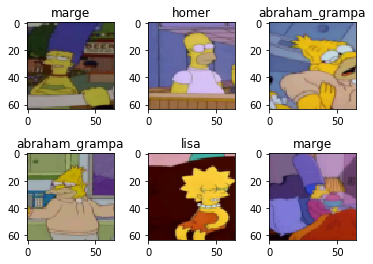

The shape of the image is (64, 64, 3)


In [0]:
def visualize(data, labels, idx=0):
    fig = plt.figure()
    for i in range(6):
        ax = fig.add_subplot(2, 3, i + 1)
        image = data[idx]
        ax.imshow(image)
        ax.set_title(characters[labels[idx]][:-8])
        idx += 1
    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
    plt.show()

    print("The shape of the image is {}".format(image.shape))

visualize(train_data, train_labels, 0)

##Image Augmentation (Manually)

<br/>

우리가 가지고 있는 Training Set은 5092개 뿐입니다. 

Label이 6개이므로, Label당 대강 800장의 사진이 있는 것인데요, 64 * 64 * 3 = 12288개의 Feature를 가진 사진들을 Input으로 학습시키기에는 그 양이 부족합니다.

또한, 우리가 가지고 있는 사진이 General한 사진들이 아닐 수도 있습니다.

가령, 왼쪽만 보고 있는 Homer Simpson만 있을 수도 있는 것이죠!

따라서, Image Augmentation을 통해 Image를 변형시켜, 더 General하고, 더 큰 Dataset을 만들어 주어야 합니다.

이미지를 뒤집어서 Dataset에 추가해 주는 작업을 해볼까요?

아래의 **flip_horizontal**, **filp_vertical** function들을 완성해 보세요!

<br/>

###flip_horizontal

<br/>

input : **image**, which is a numpy array with shape (64, 64, 3)

flip the **image** along a horizontal axis in the middle and save the result to **image_flipped**

output : **image_flipped**, which is a numpy array with shape (64, 64, 3)

**hint** : [[np.fliplr](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fliplr.html)]

<br/>

In [0]:
def flip_horizontal(image):
    image_flipped = np.fliplr(image)
    return image_flipped

###flip_vertical

<br/>

input : **image**, which is a numpy array with shape (64, 64, 3)

flip the **image** along a horizontal axis in the middle and save the result to **image_flipped**

output : **image_flipped**, which is a numpy array with shape (64, 64, 3)

**hint** : [[np.flipud](https://docs.scipy.org/doc/numpy/reference/generated/numpy.flipud.html)]

<br/>

In [0]:
def flip_vertical(image):
    image_flipped = np.flipud(image)
    return image_flipped

###Flip Images in Training / Validation Set

<br/>

**train_data**의 사진들을 Horizontal하게, 그리고 Vertical하게 Flip해서 **train_data_flipped**에 저장합니다.

그에 따라, **train_labels_flipped**도 만들어 주어야겠죠?

Validation Set에 대해서도 위를 적용해 주세요!

<br/>

In [0]:
train_data_flipped = []
train_labels_flipped = []
val_data_flipped = []
val_labels_flipped = []

for i in range(len(train_data)):
    train_data_flipped.append(flip_horizontal(train_data[i]))
    train_labels_flipped.append(train_labels[i])
    train_data_flipped.append(flip_vertical(train_data[i]))
    train_labels_flipped.append(train_labels[i])

for i in range(len(val_data)):
    val_data_flipped.append(flip_horizontal(val_data[i]))
    val_labels_flipped.append(val_labels[i])
    val_data_flipped.append(flip_vertical(val_data[i]))
    val_labels_flipped.append(val_labels[i])
    
train_data_flipped = np.array(train_data_flipped)
train_labels_flipped = np.array(train_labels_flipped)
val_data_flipped = np.array(val_data_flipped)
val_labels_flipped = np.array(val_labels_flipped)

In [0]:
# Check Shape
print('Flipped Train Data Shape : {}'.format(str(train_data_flipped.shape)))
print('Flipped Train Label Shape : {}'.format(str(train_labels_flipped.shape)))
print('Flipped Validation Data Shape : {}'.format(str(val_data_flipped.shape)))
print('Flipped Validation Label Shape : {}'.format(str(val_labels_flipped.shape)))

###Visualize Filpped Dataset

<br/>

Flip이 잘 되었는지 확인해 볼까요?

<br/>

In [0]:
visualize(train_data_flipped, train_labels_flipped)
visualize(val_data_flipped, val_labels_flipped)

###Add Flipped Dataset to Original Dataset

<br/>

Flip된 Dataset을 원래의 Dataset에 Append해 줍니다.

**train_data**에 **train_data_flipped**를 Append하고, **train_labels**에 **train_labels_flipped**를 Append하면 되겠죠?

Validation Set에 대해서도 마찬가지 작업을 해주시면 됩니다.

그 다음, Dataset의 Shape를 출력해 보면, Data의 개수가 원래 크기의 3배가 되었겠죠?

**hint** : [[np.append](https://docs.scipy.org/doc/numpy/reference/generated/numpy.append.html)]의 **axis**에 주의하세요!

<br/>

In [0]:
train_data = np.append(train_data, train_data_flipped, axis=0)
train_labels = np.append(train_labels, train_labels_flipped)
val_data = np.append(val_data, val_data_flipped, axis=0)
val_labels = np.append(val_labels, val_labels_flipped)

In [0]:
# Check Shape
print('Train Data Shape : {}'.format(str(train_data.shape)))
print('Train Label Shape : {}'.format(str(train_labels.shape)))
print('Validation Data Shape : {}'.format(str(val_data.shape)))
print('Validation Label Shape : {}'.format(str(val_labels.shape)))

##Image Augmenation (Keras)

<br/>

Keras의 **ImageDataGenerator**로도 Image Augmentation이 가능합니다!

**ImageDataGenerator**를 통해, Image Normalization, Whitening, Rotation, Flip, Crop 등을 쉽게 할 수 있습니다.

사용법은 아래와 같습니다.

[[Keras ImageDataGenerator Documentation](https://keras.io/preprocessing/image/)]

<br/>

###Reset Dataset (If you Augmented the Image from Above)

<br/>

위에서 Dataset을 Flip하고 원래 Dataset에 추가해 주었다면, 아래 코드 셀들을 실행하여 Dataset을 Flip 이전 상태로 돌려주세요.

<br/>

In [0]:
# Separate into Train / Val
n_train_data = round(len(simpsons_labels) * 0.7)
train_data = simpsons_data[ : n_train_data]
train_labels = simpsons_labels[ : n_train_data]
val_data = simpsons_data[n_train_data : ]
val_labels = simpsons_labels[n_train_data : ]

# Reshape Vector into Tensor
train_data = train_data.reshape((train_data.shape[0], 64, 64, -1))
val_data = val_data.reshape((val_data.shape[0], 64, 64, -1))

# Check Shape
print('Train Data Shape : {}'.format(str(train_data.shape)))
print('Train Label Shape : {}'.format(str(train_labels.shape)))
print('Validation Data Shape : {}'.format(str(val_data.shape)))
print('Validation Label Shape : {}'.format(str(val_labels.shape)))

###Actual Augmentation

<br/>

ImageDataGenerator의 **apply_transform** function을 이용하면, 사진을 원하는 대로 변형할 수 있습니다.

사진을 어떻게 변형시킬지는, **transform_params** Dictionary의 값들을 조정하여 결정할 수 있습니다.

Dictionary의 각 Key들이 무엇을 의미하는지는 아래에 있습니다.

값들을 적절히 조절해서 사진을 변형해 보세요!

<br/>

###Transform Parameters Under Consideration

<br/>

**'theta'** : Float. Rotation angle in degrees.

**'tx'** : Float. Shift in the x direction.

**'ty'** : Float. Shift in the y direction.

**'shear'** : Float. Shear angle in degrees.

**'zx'** : Float. Zoom in the x direction.

**'zy'** : Float. Zoom in the y direction.

**'flip_horizontal'** : Boolean. Horizontal flip.

**'flip_vertical'** : Boolean. Vertical flip.

**'channel_shift_intencity'** : Float. Channel shift intensity.

**'brightness'** : Float. Brightness shift intensity.

<br/>

In [0]:
import tensorflow as tf

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
train_data_transformed = []
train_labels_transformed = []
val_data_transformed = []
val_labels_transformed = []

for i in range(len(train_data)):
    train_labels_transformed.append(train_labels[i])
    data_tmp = train_data[i] * 255
    data_tmp = data_tmp.astype(int)
    train_data_transformed.append(datagen.apply_transform(x=data_tmp, transform_parameters={'theta':40, 'brightness':0.8}) / 255)

for i in range(len(val_data)):
    val_labels_transformed.append(val_labels[i])
    data_tmp = val_data[i] * 255
    data_tmp = data_tmp.astype(int)
    val_data_transformed.append(datagen.apply_transform(x=val_data[i] * 255, transform_parameters={'theta':40, 'brightness':0.8}) / 255)
    
train_data_transformed = np.array(train_data_transformed)
train_labels_transformed = np.array(train_labels_transformed)
val_data_transformed = np.array(val_data_transformed)
val_labels_transformed = np.array(val_labels_transformed)

In [0]:
# Check Shape
print('Transformed Train Data Shape : {}'.format(str(train_data_transformed.shape)))
print('Transformed Train Label Shape : {}'.format(str(train_labels_transformed.shape)))
print('Transformed Validation Data Shape : {}'.format(str(val_data_transformed.shape)))
print('Transformed Validation Label Shape : {}'.format(str(val_labels_transformed.shape)))

###Visualize Transformed Dataset

<br/>

Transform이 잘 되었는지 확인해 볼까요?

<br/>

In [0]:
visualize(train_data_transformed, train_labels_transformed)
visualize(val_data_transformed, val_labels_transformed)

###Add Transformed Dataset to Original Dataset

<br/>

Transform된 Dataset을 원래의 Dataset에 Append해 줍니다.

**train_data**에 **train_data_transformed**를 Append하고, **train_labels**에 **train_labels_transformed**를 Append하면 되겠죠?

Validation Set에 대해서도 마찬가지 작업을 해주시면 됩니다.

그 다음, Dataset의 Shape를 출력해 보면, Data의 개수가 원래 크기의 2배가 되었겠죠?

**hint** : [[np.append](https://docs.scipy.org/doc/numpy/reference/generated/numpy.append.html)]의 **axis**에 주의하세요!

<br/>

In [0]:
train_data = np.append(train_data, train_data_transformed, axis=0)
train_labels = np.append(train_labels, train_labels_transformed)
val_data = np.append(val_data, val_data_transformed, axis=0)
val_labels = np.append(val_labels, val_labels_transformed)

In [0]:
# Check Shape
print('Train Data Shape : {}'.format(str(train_data.shape)))
print('Train Label Shape : {}'.format(str(train_labels.shape)))
print('Validation Data Shape : {}'.format(str(val_data.shape)))
print('Validation Label Shape : {}'.format(str(val_labels.shape)))

## Construct Model

<br/>

Keras로 Model을 만드는 것은 많이 연습했었죠?

첫 Layer의 **input_shape**는 (64, 64, 3) 으로 설정해 주시고, 나머지 Layer들은 자유롭게 추가해 주세요!

이때, Hyperparameter들을 적절히 선택해 주어야겠죠?

<br/>

###Hyperparameters Under Consideration

<br/>

**Activation**

RELU...? Sigmoid...? Tanh...? Maxout...?

Can be added via, **tf.keras.layers.Dense( ... , activation=?)**

? 안을 적절한 Activation Function으로 채우면 됩니다!

Activation Function의 종류는, 아래 Documentation에 잘 정리되어 있습니다.

[[Keras Activation Documentation](https://keras.io/activations/)]

<br/>

**Regularization**

L1 or L2 Regularizer...? Regularization Strength...?

Can be added via, **tf.keras.layers.Dense( ... , kernel_regularizer=tf.keras.regularizers.l2(0.01))**

괄호 안의 숫자가 Regularization Strength입니다. L1을 쓰려면, **regularizers.l1**을 쓰면 되겠죠?

[[Keras Regularizer Documentation](https://keras.io/regularizers/)]

<br/>

**Weight Initialization**

How should we set the initial values of the weight...?

Can be added via, **tf.keras.layers.Dense( ... , kernel_initializers=?)**

? 를 적절한 Initializer로 채워주면 됩니다.

Normal Distribution을 사용하려면, **tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)**

Xavier Initialization을 사용하려면, **tf.keras.initializers.glorot_normal(seed=None)**

을 사용하면 됩니다!

더 다양한 Initializer들은 Documentation에 나와 있습니다!

[[Keras Initizlizer Documentation](https://keras.io/initializers/)]

<br/>

**Batch Normalization**

Layer의 출력에 대해 Batch Normalization을 하려면,

**tf.keras.layers.BatchNormalization()**을 model에 추가해 주세요!

[[Keras Normalization Documentation](https://keras.io/layers/normalization/)]

<br/>

**Optimizer**

SGD...? RMSProp...? Nesterov Momentum...? Adam...? Learning Rate Decay...?

Can be added in, **model.compile(optimizer=?, ... )**

? 안을 적절한 Optimizer로 채우시면 됩니다. 

동시에, Learning Rate도 같이 정의해 주세요! Learning Rate의 Decay Rat 또한 설정 가능합니다!!

이것은 Documentation을 보는 것이 더 도움이 될 것 같습니다.

[[Keras Optimizer Documentation](https://keras.io/optimizers/)]

<br/>

**Loss Function**

Multiclass SVM Loss...? Cross-Entropy Loss...?

Can be added in, **model.compile( ..., loss=?, ... )**

Multiclass SVM Loss의 경우, **categorical_hinge**

Cross-Entropy Loss의 경우, **sparse_categorical_crossentropy** or **categorical_crossentropy**

(후자의 경우, label들이 one-hot vector이어야 하죠??)

[[Keras Loss Documentation](https://keras.io/losses/)]

<br/>

In [0]:
import tensorflow as tf

In [0]:
model = tf.keras.Sequential([
    '''
    YOUR MODEL ARCHITECTURE HERE
    '''
])

model.compile(optimizer='''YOUR OPTIMIZER HERE''',
             loss='''YOUR LOSS FUNCTION HERE''',
             metrics=['accuracy'])

model.summary()

## Train Model

<br/>

위에서 정의한 Model을 학습시킵시다!

<br/>

In [0]:
hist = model.fit(train_data, train_labels, epochs=10, batch_size=100, validation_data=(val_data, val_labels), validation_freq=1)

## Model Visualization

<br/>

학습시킨 Model의 성능이 어느정도인지 확인합니다.

Overfitting이나 Underfitting이 일어난 것 같다면, Hyperparameter를 바꿔줘야겠죠?

Hyperparameter를 바꿔서 Model을 다시 Compile하고, Train해 보세요!!

<br/>

In [0]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

##Export Model

<br/>

Model의 Architecture와 Parameter를 External File로 Export합니다.

이렇게 Export한 File로 학습시킨 Model을 Reconstruct할 수 있습니다!!

아래 코드 셀의 **model_name** 변수에 자신의 Model 이름을 작은따옴표 안에 넣어 저장해 주세요!

Ex) model_name = 'jaehyunlee'

<br/>

In [0]:
model_name = '''YOUR MODEL NAME HERE'''

In [0]:
import json

In [0]:
# Save weights
model_weights = model_name + '_simpsonslab_weights.h5'
model.save_weights(model_weights)
# Save model architecture
model_architecture = model_name + '_simpsonslab_architecture.json'
with open(model_architecture, 'w') as f:
    f.write(model.to_json())

In [0]:
# Download files on Colab into Local Directory
from google.colab import files
files.download(model_weights)
files.download(model_architecture)

##Check if Model was correcly exported

<br/>

위에서 Export한 File이 잘 저장되었나 확인합니다.

아래 코드 셀들을 실행하여 **"Exported Model and Current Model are the Same"**이 나오면 문제없이 Export된 것입니다.

아니라면, 런타임을 초기화해서 다시 실행해 보세요...!

<br/>

In [0]:
with open(model_architecture, 'r') as f:
    model_dummy = tf.keras.models.model_from_json(f.read())
model_dummy.load_weights(model_weights)

In [0]:
predict = model.predict(val_data)
predict_dummy = model_dummy.predict(val_data)

for i in range(len(val_data)):
    if np.argmax(predict[i]) != np.argmax(predict_dummy[i]):
        print("Exported Model and Current Model are Different...")
        break
    if i == len(val_data) - 1:
        print("Exported Model and Current Model are the Same")

##How do I look?

<br/>

자신이 어떤 심슨 캐릭터와 닮았는지 볼까요?

셀카를 업로드해주세요!

<br/>

In [0]:
uploaded = files.upload()

이미지 파일을 업로드한 후, 위의 코드 셀에서 출력된 파일 이름을 아래의 **my_img = im.io.imread('   ?   ')** 의 **?**에 넣어 주세요!

Ex) 코드 셀의 출력이 **Saving 1.jpg to 1.jpg**라면, **my_img = im.io.imread('1.jpg')** 라고 써주세요!

In [0]:
my_img = im.io.imread('1.jpg')
my_img = im.transform.resize(my_img, (64, 64, 3))

In [0]:
# Visualize my image
im.io.imshow(my_img)
plt.show()

# Reshape my image so that model is applicable
my_img = my_img.reshape((1, 64, 64, 3))

# Predict on my image
prediction = model.predict(my_img)
print('\nPrediction : {}\n'.format(characters[np.argmax(prediction[0])]))
for i in range(len(prediction[0])):
    print('{character} : {confidence:0.2f}%'.format(character=characters[i], confidence=prediction[0][i] * 100), end='\t')
    if (i + 1) % 7 == 0:
        print("\n")
print('\n')

##The Spinning Marge Challenge

<br/>

만든 Model이 회전하는 Marge를 잘 인식하는지를 볼까요?

<br/>

###Generate Spinning Marge Dataset

In [0]:
rand_num = np.random.randint(low=0, high=1000)
marge_img = []
cnt = 0
for i in range(len(simpsons_labels)):
    if simpsons_labels[i] == 4:
        cnt += 1
        if cnt == rand_num:
            marge_img = simpsons_data[i]
            break
marge_img = marge_img.reshape((64, 64, 3))
marge_img = marge_img * 255
marge_img = marge_img.astype(int)

spinning_marge = []

for i in range(6):
    spinning_marge.append(datagen.apply_transform(x=marge_img, transform_parameters={'theta':i * 60}) / 255)

spinning_marge = np.array(spinning_marge)

###Make Predictions

In [0]:
# Predict on Spinning Marge
prediction = model.predict(spinning_marge)
prediction = np.argmax(prediction, axis=1)

visualize(spinning_marge, prediction)